

# <a href='https://github.com/datamllab/rlcard'> <center> <img src='https://miro.medium.com/max/1000/1*_9abDpNTM9Cbsd2HEXYm9Q.png' width=500 class='center' /></a> 

## **Training CFR on Leduc Hold'em**
In this tutorial, we will showcase a more advanced algorithm CFR, which uses `step` and `step_back` to traverse the game tree.

First, we install RLcard and PyTorch.

In [1]:
!pip install rlcard[torch]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.5/265.5 KB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 4.1 MB/s eta 0:00:00
  Created wheel for rlcard: filename=rlcard-1.1.0-py3-none-any.whl size=322198 sha256=19e7140096eb624b339850b764634949be5fc66b524478df00d171634530aa46
  Stored in directory: /root/.cache/pip/wheels/1d/a8/66/5a7a7be9d7d0607ec8cabde164f3b44694800f394736ce56a4
Successfully built rlcard


Then we import all the classes and functions we need.

In [2]:
import rlcard
from rlcard.agents import (
    CFRAgent,
    RandomAgent,
)
from rlcard.utils import (
    tournament,
    Logger,
    plot_curve,
)

We make two environments, where one allows `step_back` so that CFR can traverse the tree, and the other for evaluation only.

In [3]:
env = rlcard.make(
        'leduc-holdem',
        config={
            'allow_step_back': True,
        }
    )
eval_env = rlcard.make(
    'leduc-holdem',
)

We create the CFR agent.

In [4]:
agent = CFRAgent(
    env,
    "experiments/leduc_holdem_cfr_result/cfr_model",
)

Here, we save the trained model in the path `experiments/leduc_holdem_cfr_result/cfr_model`. Then we use a random agent as the opponent.

In [5]:
eval_env.set_agents([
    agent,
    RandomAgent(num_actions=env.num_actions),
])

Now we start training for `1000` iterations, i.e., 1000 games.

In [6]:
with Logger("experiments/leduc_holdem_cfr_result") as logger:
    for episode in range(1000):
        agent.train()
        print('\rIteration {}'.format(episode), end='')
        # Evaluate the performance. Play with Random agents.
        if episode % 50 == 0:
            logger.log_performance(
                env.timestep,
                tournament(
                    eval_env,
                    10000,
                )[0]
            )

    # Get the paths
    csv_path, fig_path = logger.csv_path, logger.fig_path

Iteration 0
----------------------------------------
  episode      |  192
  reward       |  -0.01665
----------------------------------------
Iteration 50
----------------------------------------
  episode      |  9792
  reward       |  0.77585
----------------------------------------
Iteration 100
----------------------------------------
  episode      |  19392
  reward       |  0.7854
----------------------------------------
Iteration 150
----------------------------------------
  episode      |  28992
  reward       |  0.78825
----------------------------------------
Iteration 200
----------------------------------------
  episode      |  38592
  reward       |  0.80715
----------------------------------------
Iteration 250
----------------------------------------
  episode      |  48192
  reward       |  0.85315
----------------------------------------
Iteration 300
----------------------------------------
  episode      |  57792
  reward       |  0.8147
--------------------------

We can plot the learning curve

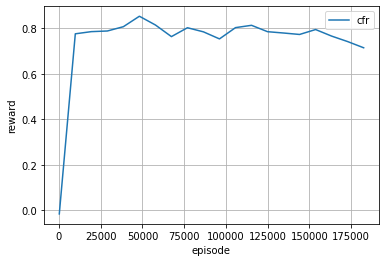

In [7]:
plot_curve(csv_path, fig_path, 'cfr')

Good job! Now you have your trained CFR agent on Leduc Hold'em!

In [13]:
print(">> Leduc Hold'em trained model")

import rlcard
from rlcard import models
from rlcard.agents import LeducholdemHumanAgent as HumanAgent
from rlcard.utils import print_card


env = rlcard.make('leduc-holdem')
human_agent = HumanAgent(env.num_actions)
cfr_agent = models.load('leduc-holdem-cfr').agents[0]
env.set_agents([
    human_agent,
    cfr_agent,
])

while (True):
    print(">> Start a new game")

    trajectories, payoffs = env.run(is_training=False)
    # If the human does not take the final action, we need to
    # print other players action
    final_state = trajectories[0][-1]
    action_record = final_state['action_record']
    state = final_state['raw_obs']
    _action_list = []
    for i in range(1, len(action_record)+1):
        if action_record[-i][0] == state['current_player']:
            break
        _action_list.insert(0, action_record[-i])
    for pair in _action_list:
        print('>> Player', pair[0], 'chooses', pair[1])

    # Let's take a look at what the agent card is
    print('===============     CFR Agent    ===============')
    print_card(env.get_perfect_information()['hand_cards'][1])


    print('===============     Result     ===============')
    if payoffs[0] > 0:
        print('You win {} chips!'.format(payoffs[0]))
    elif payoffs[0] == 0:
        print('It is a tie.')
    else:
        print('You lose {} chips!'.format(-payoffs[0]))
    print('')

    inputs = input("Press any key to continue, Q to exit\n")
    if inputs.lower() == "q":
      break

>> Leduc Hold'em trained model
>> Start a new game
>> Player 1 chooses raise

=============== Community Card ===============
┌─────────┐
│░░░░░░░░░│
│░░░░░░░░░│
│░░░░░░░░░│
│░░░░░░░░░│
│░░░░░░░░░│
│░░░░░░░░░│
│░░░░░░░░░│
└─────────┘
===============   Your Hand    ===============
┌─────────┐
│J        │
│         │
│         │
│    ♠    │
│         │
│         │
│        J│
└─────────┘
===============     Chips      ===============
Yours:   ++
Agent 1: ++++
=========== Actions You Can Choose ===========
0: call, 1: raise, 2: fold

>> You choose action (integer): 0
>> Player 1 chooses check

=============== Community Card ===============
┌─────────┐
│K        │
│         │
│         │
│    ♥    │
│         │
│         │
│        K│
└─────────┘
===============   Your Hand    ===============
┌─────────┐
│J        │
│         │
│         │
│    ♠    │
│         │
│         │
│        J│
└─────────┘
===============     Chips      ===============
Yours:   ++++
Agent 1: ++++
=========== Action